# Directed Configuration Model Simulation

In [1]:
# Importing libraries

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

We consider simulating the directed configuration model. Firstly we describe the procedure for sampling the degrees. Suppose $(D^-, D^+)$ a $\mathbb N \times \mathbb N$ valued random variable

1. Sample a sequence $(D^-_1, D^+_1), \ldots, (D^-_n, D^+_n)$ of i.i.d. copies of $(D^-, D^+)$
2. Compute
$$ \Delta_n = \sum_{i=1}^n (D^-_i - D^+_i) $$
3. Repeat steps 1 and 2 until
$$ \lvert \Delta_n \rvert \leq n^{1 - \kappa + \delta}$$
4. Randomly sample indices $\{i_1, i_2, \ldots, i_{\lvert \Delta_n \rvert} \}$ without replacement
5. If $\Delta_n > 0$ then increment $D^+_{i_j}$ by 1 for $j = 1, \ldots, \lvert \Delta_n \rvert$, otherwise increment by $D^-_{i_j}$ for $j = 1, \ldots, \lvert \Delta_n \rvert$

In [2]:
def sample_degree_sequence(in_out_degrees, n, kappa = 1/2, delta = 1/10, require_graphical = False):
    """
    Given a sampler for i.i.d. in and out degrees, this generates a degree sequence of length n
    such that the total in and out degree is equal.
    
    Parameters:
    in_out_degrees (function): A function which takes n and returns a length n in-degree array
                               and a length n out-degree array 
    (int): The length of the degree sequence to sample    
    kappa (float): A constant relating to how many moments the degree distribution has
    delta (float): A tolerance parameter
    require_graphical (boolean): If true then the sequence is repeatedly sampled until it is graphical
    
    Returns:
    in_degrees (numpy array): A in-degree array of length n
    out_degrees: A out-degree array of length n
    """
    
    repeat_till_graphical = True
    
    while repeat_till_graphical:
    
        unbalanced = True

        while unbalanced:
            in_degrees, out_degrees = in_out_degrees(n)

            degree_difference = np.sum(in_degrees - out_degrees)

            unbalanced = (np.abs(degree_difference) > np.power(n, 1 - kappa + delta))

        fill_indices = np.random.choice(n, np.abs(degree_difference), replace=False)

        for i in fill_indices:
            if degree_difference >= 0:
                out_degrees[i] += 1
            else:
                in_degrees[i] += 1
                
        repeat_till_graphical = require_graphical and not nx.is_digraphical(in_degrees, out_degrees)
            
    return in_degrees, out_degrees

The networkX package provides the function for generating the directed configuration model given a degree sequence. This is obtained by uniformly pairing off the in and out half edges. There are then two approaches to getting a simple graph. The first is the repeated DCM. In this method we just repeat the procedure until the resulting graph is simple. Mathematically this has the effect of conditioning that the pairing gives a simple graph.

Not all degree sequences can generate a simple graph though, we call the ones that do graphical. A necessary and sufficient condition for a degree sequence to be graphical is

1. $\sum_{i=1}^n D^-_i = \sum_{i=1}^n D^+_i$,
2. and $\sum_{i=1}^n \min\{D^+_i, \lvert A - \{v_i\} \rvert\} \geq \sum_{v_i \in A} D^-_i$ for any $A \subset V$.

The second approach is to just erase all loops and collapse all multi-edges. This will alter the degree sequence but is algorithmically very efficient. This is the erased DCM.

In [18]:
def is_simple(G):
    """
    Takes as input a multigraph and checks if the graph is simple
    """
    seen_edges = {}
    
    for (v, w) in G.edges:
        if edges in seen_edges or v == w:
            return False
        
    return True

def repeated_dcm(degree_sequence):
    """
    Generates a multigraph by repeating the repeatedly sampling a DCM until the graph is simple
    """
    
    # checking if sequence is graphical
    if not nx.is_digraphical(in_degrees, out_degrees):
        raise InputError("Running repeated DCM with a non-graphical sequence")
    
    is_simple = False
    
    while not is_simple:
        G =  nx.directed_configuration_model(in_degrees, out_degrees)
        is_simple = is_simple(G)
        
    return G

def erased_dcm(degree_sequence):
    """
    Generates a multigraph by sampling a DCM and collapsing multiedges and removing loops
    """
    
    G = nx.directed_configuration_model(in_degrees, out_degrees)
    
    G = nx.DiGraph(D) # collapsing multiedges
    G.removed_edges_from(nx.selfloop_edges(G)) # removing loops
    
    return G

We define ways of sampling a critical in-degree out-degree pair with a specified correlation $\rho = \text{Corr}(D^-, D^+)$.

- If $\rho = 0$ then take $D^- \sim \text{Poisson}(1)$ and $D^+ \sim \text{Poisson(1)}$ independently.

- If $\rho \in \left(0, \frac{1}{2}\right)$ then set
$$ k = \frac{1-2\rho}{\rho}, \quad \theta = \frac{\rho}{1-\rho}. $$
Sample $\Lambda \sim \text{Gamma}(k, \theta)$ (using a scale parametrisation, not rate). Conditional on $\Lambda$ sample $D^- \sim \text{Poisson}(\Lambda)$ and $D^+ \sim \text{Poisson}(\Lambda)$ independently.

- If $\rho \in (-1, 0)$ then let
$$ L = \frac{2}{1 + \rho}, \quad \alpha = -\frac{1}{2} \frac{1 + \rho}{\rho}. $$
Sample $\Lambda \sim \text{Beta}(\alpha, \alpha)$. conditional on $\Lambda$ sample $D^- \sim \text{Poisson}(L \Lambda)$ and $D^+ \sim \text{Poisson}(L(1 - \Lambda))$ indepedently.

In [4]:
def poisson_degrees(n, rho):
    """
    Given a correlation rho, generates a i.i.d. sequence of in and out degrees satisfiying the
    criticality condition with correlation rho.
    """
    if rho == 0:
        in_rate = 1
        out_rate = 1

    if 0 < rho and rho < 0.5:
        k = (1 - 2 * rho) / rho
        theta = rho / (1 - rho)
        Lambda = np.random.gamma(k, theta, n)

        in_rate = Lambda
        out_rate = Lambda

    if -1 < rho and rho < 0:
        L = 2 / (1 + rho)
        alpha = -0.5 * (1 + rho) / rho
        Lambda = np.random.beta(alpha, alpha, n)
        
        in_rate = L * Lambda
        out_rate = L * (1 - Lambda)

    return np.random.poisson(in_rate, n), np.random.poisson(out_rate, n)
            

In [5]:
# testing poisson_degrees gives a critical sequence with the correct correlation

n = 100000
corr = 0.4 # change me and check the empircal means and corr looks right

in_degrees, out_degrees = poisson_degrees(n, corr)

print("Mean in-degree: {0:f}".format(np.mean(in_degrees)))
print("Mean out-degree: {0:f}".format(np.mean(out_degrees)))
print("Mean of product: {0:f}".format(np.mean(in_degrees * out_degrees)))
print("Correlation: {0:f}".format(np.corrcoef(in_degrees, out_degrees)[1, 0]))

Mean in-degree: 0.334860
Mean out-degree: 0.338260
Mean of product: 0.339950
Correlation: 0.406432


For convenience let's define a function for sampling a directed Erdős-Reniy graph.

In [6]:
def directed_gnp(n, p):
    """
    Samples the directed Erdos Renyi model on n vertices where each directed edge is present
    independently with probability p.
    """

    forward_graph = nx.fast_gnp_random_graph(n, p)
    backward_graph = nx.fast_gnp_random_graph(n, p)
    
    G = nx.DiGraph()
    
    for (v, w) in forward_graph.edges:
        [x, y] = sorted([v, w])
        G.add_edge(x, y)
        
    for (v, w) in backward_graph.edges:
        [y, x] = sorted([v, w])
        G.add_edge(x, y)
        
    return G

Firstly we plot a histogram for the size of the largest scc.

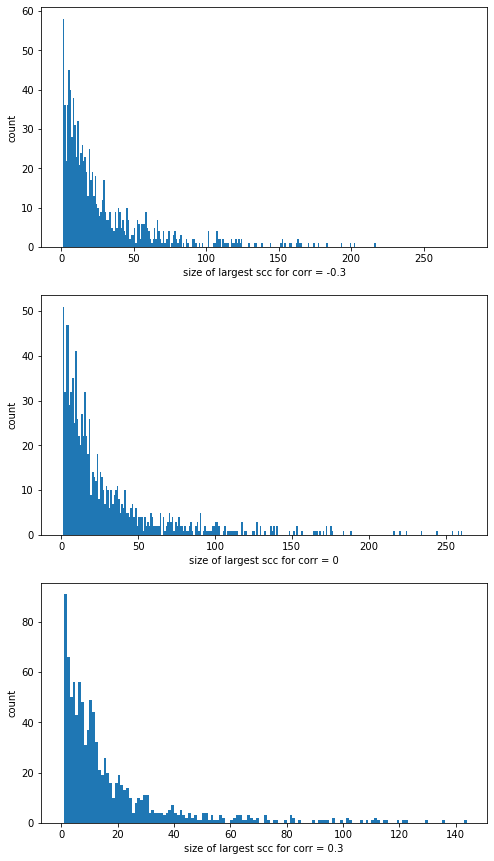

In [10]:
# parameters

tries = 1000
n = 10000
corr_list = [-0.3, 0, 0.3]

# setting up axes
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(8, 15))

# simulation and plotting
for corr, ax in zip(corr_list, [ax1, ax2, ax3]):
    largest_scc_size_list = []

    for _ in range(tries):
        # sampling the configuration model
        in_degrees, out_degrees = sample_degree_sequence(lambda n: poisson_degrees(n, corr), n)
        G = nx.directed_configuration_model(in_degrees, out_degrees)
        
        # finding largest scc
        largest_scc = max(nx.strongly_connected_components(G), key = len)
        
        # recording size of largest scc
        largest_scc_size_list.append(len(largest_scc))
    
    # plotting the histogram
    ax.hist(largest_scc_size_list, bins=range(max(largest_scc_size_list)))
    ax.set_xlabel("size of largest scc for corr = {0}".format(corr))
    ax.set_ylabel("count")

Next we try drawing the largest scc.

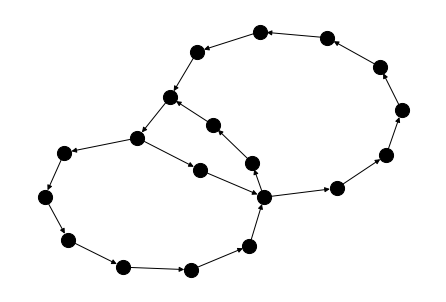

In [100]:
# parameters

n = 10000
corr = -0.9

drawing_parameters = {
    "node_size": 200,
    "node_color": "black"
}

# sampling directed configuration model
in_degrees, out_degrees = sample_degree_sequence(lambda n: poisson_degrees(n, corr), n)
G = nx.directed_configuration_model(in_degrees, out_degrees)

# finding the largest scc
largest_scc_vertices = max(nx.strongly_connected_components(G), key = len)
largest_scc = G.subgraph(largest_scc_vertices)

nx.draw_kamada_kawai(largest_scc, **drawing_parameters)

We define a function which collapses scc's into a multigraph with minimum degree 3.

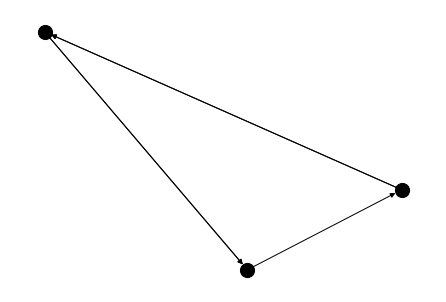

In [101]:
def collapse(G):
    H = nx.MultiDiGraph() # the multigraph we return
    
    removable_vertices = {v for v in G if G.degree(v) == 2}
    
    # account for loops and singletons
    if len(removable_vertices) == len(G):
        H.add_edge(0, 0, weight = len(G) - 1)
        return H
    
    # finding all paths of vertices with degree 2
    paths = []
    while removable_vertices:    
        path_length = 0
        v = removable_vertices.pop()
        
        # following in-path
        start_vertex = v
        while G.degree(start_vertex) == 2:
            start_vertex = next(G.predecessors(start_vertex))
            removable_vertices.discard(start_vertex)
            path_length += 1
        
        # following out-path
        end_vertex = v
        while G.degree(end_vertex) == 2:
            end_vertex = next(G.successors(end_vertex))
            removable_vertices.discard(end_vertex)
            path_length += 1
            
        paths.append((start_vertex, end_vertex, path_length))
    
    # adding an edge in the collapsed graph with the weight the length of the path
    for (v, w, weight) in paths:
        H.add_edge(v, w, weight=weight)
        
    # add edges joining nodes of degree at least 3
    for v in G:
        if G.degree(v) >= 3:
            for w in G.successors(v):
                if G.degree(w) >= 3:
                    H.add_edge(v, w, weight=1)
        
    return H

nx.draw_kamada_kawai(collapse(largest_scc), **drawing_parameters)